# Normative modelling of brain structural deviations

This notebook implements a normative modelling approach to quantify structural brain deviations in individuals with spinal cord injury (SCI), with and without neuropathic pain. Using age- and sex-matched normative data, we estimate individual deviations (residuals) in cortical thickness and subcortical volumes.

The workflow includes:


This approach enables the identification of brain regions with structural alterations beyond expected age-related variation, supporting the study of neuroanatomical correlates of pain in SCI.


## Import libaries


In [3]:
import pandas as pd
from openpyxl.styles.builtins import title
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.stats import shapiro, iqr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway, kruskal
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
import matplotlib.gridspec as gridspec
import os
import re
import scikit_posthocs as sp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import warnings
# Suppress specific PerformanceWarning
warnings.filterwarnings("ignore")

### Loading data files

1. Structural Information and Subject inforamtion: The adjusted values extracted from Braincharts including patient information.
2. Normative values females: Reference data containing age- and sex-specific normative values for brain structures in healthy females, used as baseline for comparison
3. Normative values males: Reference data containing age- and sex-specific normative values for brain structures in healthy males, used as baseline for comparison

In [4]:
# Structural Information and Subject inforamtion
file_path =  "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Adaption_Results_New/Rescaled/Exctracted_Adjusted_Values_New.xlsx"
df = pd.read_excel(file_path)
# Normative values females
normative_values_female= "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Extraction Normative Values/normative_values_females.xlsx"
df_norm_females= pd.read_excel(normative_values_female)
# Normative values males
normative_values_male = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Extraction Normative Values/normative_values_males.xlsx"
df_norm_males= pd.read_excel(normative_values_male)

### Renaming Volumes

In [5]:
# Define cohort order and colors
cohort_order = [ "SCI_nNP", "SCI_NP"]
cohort_labels = [ "SCI without neuropathic pain", "SCI with neuropathic pain"]
# Define cohort colors
cohort_palette = {
    "SCI_nNP": "#FFCC99",
    "SCI_NP": "#99D8A0"
}
# Define cohort order
cohort_order = [ "SCI_nNP", "SCI_NP"]
cohort_labels = [ "SCI without neuropathic pain", "SCI with neuropathic pain"]
# Define cohort colors
cohort_palette = {
    "SCI_nNP": "#FFCC99",
    "SCI_NP": "#99D8A0"
}
# Define subcortical volume regions
subcortical_volumes = [
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CSF",
    "EstimatedTotalIntraCranialVol",
    "Left-Accumbens-area",
    "Left-Amygdala",
    "Left-Caudate",
    "Left-Cerebellum-Cortex",
    "Left-Cerebellum-White-Matter",
    "Left-Hippocampus",
    "Left-Inf-Lat-Vent",
    "Left-Lateral-Ventricle",
    "Left-Pallidum",
    "Left-Putamen",
    "Left-VentralDC",
    "Left-choroid-plexus",
    "Left-vessel",
    "Left-Thalamus-Proper",
    "Right-Accumbens-area",
    "Right-Amygdala",
    "Right-Caudate",
    "Right-Cerebellum-Cortex",
    "Right-Cerebellum-White-Matter",
    "Right-Hippocampus",
    "Right-Inf-Lat-Vent",
    "Right-Lateral-Ventricle",
    "Right-Pallidum",
    "Right-Putamen",
    "Right-VentralDC",
    "Right-choroid-plexus",
    "Right-vessel",
    "Right-Thalamus-Proper",
    "SubCortGrayVol",
    "SupraTentorialVol",
    "SupraTentorialVolNotVent",
    "TotalGrayVol"
]

# Rename columns: Add "(Vol)" to subcortical volumes
df.rename(columns={col: f"{col} (Vol)" for col in subcortical_volumes}, inplace=True)


# Clean structural data and prepare for analysis.

subcortical_volumes = [
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CSF",
    "EstimatedTotalIntraCranialVol",
    "Left-Accumbens-area",
    "Left-Amygdala",
    "Left-Caudate",
    "Left-Cerebellum-Cortex",
    "Left-Cerebellum-White-Matter",
    "Left-Hippocampus",
    "Left-Inf-Lat-Vent",
    "Left-Lateral-Ventricle",
    "Left-Pallidum",
    "Left-Putamen",
    "Left-VentralDC",
    "Left-choroid-plexus",
    "Left-vessel",
    "Right-Accumbens-area",
    "Right-Amygdala",
    "Right-Caudate",
    "Right-Cerebellum-Cortex",
    "Right-Cerebellum-White-Matter",
    "Right-Hippocampus",
    "Right-Inf-Lat-Vent",
    "Right-Lateral-Ventricle",
    "Right-Pallidum",
    "Right-Putamen",
    "Right-VentralDC",
    "Right-choroid-plexus",
    "Right-vessel",
    "SubCortGrayVol",
    "SupraTentorialVol",
    "SupraTentorialVolNotVent",
    "TotalGrayVol"
]

In [6]:
# Smart flattening
def flatten_value(x):
    if isinstance(x, list):
        while isinstance(x, list) and len(x) > 0:
            x = x[0]
    if isinstance(x, str) and "[" in x:
        return x.strip("[]").strip()
    return x

# Apply to all columns
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and "[" in x)).any():
        print(f" Cleaning column: {col}")
        df[col] = df[col].apply(flatten_value)

# Also make sure numerical values are truly numeric
df = df.apply(pd.to_numeric, errors="ignore")
df["Sex"] = df["Sex"].astype(str).str.strip()
df["Cohort"] = df["Cohort"].astype(str).str.strip()
df_females = df[df["Sex"] == "Female"].copy()
df_males =df[df["Sex"] == "Male"].copy()

# Standardize age colume name in normative dataset
df_norm_females.rename(columns={"age": "Age"}, inplace=True)
df_norm_males.rename(columns={"age": "Age"}, inplace=True)  # optional if used later
# Ensure all plotting uses the same age column
age_col = "Age"

 Cleaning column: 3rd-Ventricle (Vol)
 Cleaning column: 4th-Ventricle (Vol)
 Cleaning column: Brain-Stem (Vol)
 Cleaning column: CSF (Vol)
 Cleaning column: EstimatedTotalIntraCranialVol (Vol)
 Cleaning column: Left-Accumbens-area (Vol)
 Cleaning column: Left-Amygdala (Vol)
 Cleaning column: Left-Caudate (Vol)
 Cleaning column: Left-Cerebellum-Cortex (Vol)
 Cleaning column: Left-Cerebellum-White-Matter (Vol)
 Cleaning column: Left-Hippocampus (Vol)
 Cleaning column: Left-Inf-Lat-Vent (Vol)
 Cleaning column: Left-Lateral-Ventricle (Vol)
 Cleaning column: Left-Pallidum (Vol)
 Cleaning column: Left-Putamen (Vol)
 Cleaning column: Left-Thalamus-Proper (Vol)
 Cleaning column: Left-VentralDC (Vol)
 Cleaning column: Left-choroid-plexus (Vol)
 Cleaning column: Left-vessel (Vol)
 Cleaning column: Right-Accumbens-area (Vol)
 Cleaning column: Right-Amygdala (Vol)
 Cleaning column: Right-Caudate (Vol)
 Cleaning column: Right-Cerebellum-Cortex (Vol)
 Cleaning column: Right-Cerebellum-White-Matter (

### Matching structural data for normative plot

# Define cohort colors and labels
cohort_order = [ "SCI_nNP", "SCI_P"]
cohort_labels = [ "SCI without neuropathic pain", "SCI with neuropathic pain"]
cohort_colors = { "SCI_nNP": "green", "SCI_P": "orange"}


In [7]:
# Function to clean and match column names
def clean_name(name):
    """Standardizes column names for easier matching."""
    return (
        name.lower()
        .replace("_and_", "&")
        .replace("_thickness", "")
        .replace("_median", "")
        .replace("_pr_int_25_lower", "")
        .replace("_pr_int_25_upper", "")
        .replace("_pr_int_95_lower", "")
        .replace("_pr_int_95_upper", "")
        .replace("_pr_int_99_lower", "")
        .replace("_pr_int_99_upper", "")
        .replace(" (vol)", "")
        .replace("-proper", "") #Removes "-proper" so that "Left-Thalamus-Proper" matches "Left-Thalamus".
        .strip()
    )

# Create a mapping between structural dataset and normative dataset columns
region_mapping = {}
for col in df:
    for norm_col in df_norm_females.columns:  # Normative dataset columns
        if clean_name(col) == clean_name(norm_col.replace("_median", "")):  # Ensure median mapping
            if "_median" in norm_col: #Only matches the median value
                region_mapping[col] = norm_col

## Print matched and unmatched values: Counts the number of matched regions and also these which are unmatched
# Initialize counters
match_count = 0
unmatched_columns = []  # List to store unmatched columns

print("\n Corrected Region Mapping (Now Matching Medians):")
for struct_col, norm_col in region_mapping.items():
    print(f"  {struct_col} → {norm_col}")
    match_count += 1  # Increment for each successful match

# Identify unmatched PyBrain columns
all_structural_columns = [col for col in df.columns if "thickness" in col or "(Vol)" in col]
unmatched_columns = [col for col in all_structural_columns if col not in region_mapping]

# Print summary
print(f"\n Total matched regions: {match_count} / {len(all_structural_columns)} (PyBrain Structural Columns)")

# Print unmatched regions
if unmatched_columns:
    print("\n The following PyBrain structural columns were NOT matched:")
    for col in unmatched_columns:
        print(f" {col}")
else:
    print("\n All PyBrain structural columns were successfully matched!")



 Corrected Region Mapping (Now Matching Medians):
  3rd-Ventricle (Vol) → 3rd-Ventricle_median
  4th-Ventricle (Vol) → 4th-Ventricle_median
  Brain-Stem (Vol) → Brain-Stem_median
  CSF (Vol) → CSF_median
  EstimatedTotalIntraCranialVol (Vol) → EstimatedTotalIntraCranialVol_median
  Left-Accumbens-area (Vol) → Left-Accumbens-area_median
  Left-Amygdala (Vol) → Left-Amygdala_median
  Left-Caudate (Vol) → Left-Caudate_median
  Left-Cerebellum-Cortex (Vol) → Left-Cerebellum-Cortex_median
  Left-Cerebellum-White-Matter (Vol) → Left-Cerebellum-White-Matter_median
  Left-Hippocampus (Vol) → Left-Hippocampus_median
  Left-Inf-Lat-Vent (Vol) → Left-Inf-Lat-Vent_median
  Left-Lateral-Ventricle (Vol) → Left-Lateral-Ventricle_median
  Left-Pallidum (Vol) → Left-Pallidum_median
  Left-Putamen (Vol) → Left-Putamen_median
  Left-Thalamus-Proper (Vol) → Left-Thalamus-Proper_median
  Left-VentralDC (Vol) → Left-VentralDC_median
  Left-choroid-plexus (Vol) → Left-choroid-plexus_median
  Left-vessel (Vo

# Plot structural deviations from normative model (female)

In [8]:
# Filter only female subjects
df_females = df[df["Sex"] == "Female"].copy()
cohort_colors = {"SCI_nNP": "green", "SCI_NP": "orange"}

# Generate plots for each matched brain feature --> with the for loop it goes through each matched brain region and generates a plot
for struct_col, norm_col in region_mapping.items():
    if norm_col in df_norm_females.columns and struct_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Define column names for percentiles

        p25_lower = f"{norm_col.replace('_median', '_pr_int_25_lower')}"
        p25_upper = f"{norm_col.replace('_median', '_pr_int_25_upper')}"
        p95_lower = f"{norm_col.replace('_median', '_pr_int_95_lower')}"
        p95_upper = f"{norm_col.replace('_median', '_pr_int_95_upper')}"
        p99_lower = f"{norm_col.replace('_median', '_pr_int_99_lower')}"
        p99_upper = f"{norm_col.replace('_median', '_pr_int_99_upper')}"

        # Ensure all necessary columns exist
        missing_cols = [col for col in [p25_lower, p25_upper, p95_lower, p95_upper, p99_lower, p99_upper] if col not in df_norm_females.columns]
        if missing_cols:
            print(f"⚠ Skipping {struct_col}: Missing columns {missing_cols}")
            continue  # Skip this region

        # Plot percentiles
        plt.fill_between(df_norm_females[age_col], df_norm_females[p25_lower], df_norm_females[p25_upper], color="blue", alpha=0.2)
        plt.fill_between(df_norm_females[age_col], df_norm_females[p95_lower], df_norm_females[p95_upper], color="blue", alpha=0.1)
        plt.fill_between(df_norm_females[age_col], df_norm_females[p99_lower], df_norm_females[p99_upper], color="blue", alpha=0.05)

        # Plot the median line
        plt.plot(df_norm_females[age_col], df_norm_females[norm_col], color="blue", linewidth=2)

        # Plot structural data points (real subject values)
        # Plot structural data points with cohort-based colors
        valid_points = df_females[[struct_col, "Age", "Cohort"]].dropna()
        if not valid_points.empty:
            for cohort in cohort_order:
                cohort_data = valid_points[valid_points["Cohort"] == cohort]
                if not cohort_data.empty:

                    plt.scatter(
                        cohort_data["Age"], cohort_data[struct_col],
                        color=cohort_colors[cohort], s=20, alpha=0.7,
                        label=cohort_labels[cohort_order.index(cohort)]
                    )
        else:
            print(f" No valid data points for {struct_col} in dataset.")

        # Labels and title
        plt.xlim(0, 100)
        plt.xlabel("Age", fontsize=14, fontweight="bold")
        plt.ylabel(struct_col.replace("_", " "), fontsize=14, fontweight="bold")
        plt.title(f"{struct_col.replace('_', ' ')} (Females)", fontweight="bold", fontsize=16)
        plt.legend(title='Cohorts')
        plt.close()

## Calculating residuals (Oberseved - Predicted)

In [9]:
def round_to_nearest_half(age):
    """Rounds age down to the nearest .0 or .5"""
    return np.floor(age * 2) / 2

# Apply the function to round ages
df_females["Rounded_Age"] = df_females["Age"].apply(round_to_nearest_half)

# Dictionary to store residuals for each structure
residuals = {}

for struct_col, norm_col in region_mapping.items():
    if norm_col in df_norm_females.columns and struct_col in df.columns:
        # Interpolate median values from the normative dataset
        predicted_values = np.interp(df_females["Rounded_Age"], df_norm_females["Age"], df_norm_females[norm_col])

        # Compute residuals (Observed - Predicted)
        df_females[f"Residual_{struct_col}"] = df_females[struct_col] - predicted_values
        residuals[struct_col] = df_females[f"Residual_{struct_col}"]
# Define cohort colors and labels
cohort_order = ["SCI_nNP", "SCI_NP"]
cohort_labels = [ "SCI without neuropathic pain", "SCI with neuropathic pain"]
cohort_colors = { "SCI_nNP": "green", "SCI_NP": "orange"}

for struct_col in residuals:
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Extract residuals and valid data points
    valid_points = df_females[[f"Residual_{struct_col}", "Rounded_Age", "Cohort"]].dropna()

    # Plot residuals colored by cohort
    for cohort in cohort_order:
        cohort_data = valid_points[valid_points["Cohort"] == cohort]
        if not cohort_data.empty:
            plt.scatter(
                cohort_data["Rounded_Age"], cohort_data[f"Residual_{struct_col}"],
                color=cohort_colors[cohort], s=20, alpha=0.7,
                label=cohort_labels[cohort_order.index(cohort)]
            )

    # Plot horizontal reference line at 0 residual
    plt.axhline(y=0, color="black", linestyle="--", linewidth=1)

    # Labels and title
    plt.xlabel("Age (rounded to nearest 0.5)", fontsize=14, fontweight="bold")
    plt.ylabel(f"Residuals ({struct_col.replace('_', ' ')})", fontsize=14, fontweight="bold")
    plt.title(f"Residuals for {struct_col.replace('_', ' ')}", fontweight="bold", fontsize=16)
    plt.legend(title="Cohort")

    plt.close()

# Load structal and normative data (males)

In [10]:
# Structural Information and Subject inforamtion
file_path = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Adaption_Results_New/Rescaled/Exctracted_Adjusted_Values_New.xlsx"
df = pd.read_excel(file_path)
# Normative values males
normative_values_male = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Extraction Normative Values/normative_values_males.xlsx"
df_norm_males= pd.read_excel(normative_values_male)

In [11]:
# Define cohort order
cohort_order = [ "SCI_nNP", "SCI_NP"]
cohort_labels = [ "SCI without neuropathic pain", "SCI with neuropathic pain"]
# Define cohort colors
cohort_palette = {
    "SCI_nNP": "#FFCC99",
    "SCI_NP": "#99D8A0"
}
# Define subcortical volume regions
subcortical_volumes = [
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CSF",
    "EstimatedTotalIntraCranialVol",
    "Left-Accumbens-area",
    "Left-Amygdala",
    "Left-Caudate",
    "Left-Cerebellum-Cortex",
    "Left-Cerebellum-White-Matter",
    "Left-Hippocampus",
    "Left-Inf-Lat-Vent",
    "Left-Lateral-Ventricle",
    "Left-Pallidum",
    "Left-Putamen",
    "Left-VentralDC",
    "Left-choroid-plexus",
    "Left-vessel",
    "Left-Thalamus-Proper",
    "Right-Accumbens-area",
    "Right-Amygdala",
    "Right-Caudate",
    "Right-Cerebellum-Cortex",
    "Right-Cerebellum-White-Matter",
    "Right-Hippocampus",
    "Right-Inf-Lat-Vent",
    "Right-Lateral-Ventricle",
    "Right-Pallidum",
    "Right-Putamen",
    "Right-VentralDC",
    "Right-choroid-plexus",
    "Right-vessel",
    "Right-Thalamus-Proper",
    "SubCortGrayVol",
    "SupraTentorialVol",
    "SupraTentorialVolNotVent",
    "TotalGrayVol"
]

# Rename columns: Add "(Vol)" to subcortical volumes
df.rename(columns={col: f"{col} (Vol)" for col in subcortical_volumes}, inplace=True)




# Clean data

In [12]:
# ✅ Smart flattening
def flatten_value(x):
    if isinstance(x, list):
        while isinstance(x, list) and len(x) > 0:
            x = x[0]
    if isinstance(x, str) and "[" in x:
        return x.strip("[]").strip()
    return x

# Apply to all columns
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and "[" in x)).any():
        print(f" Cleaning column: {col}")
        df[col] = df[col].apply(flatten_value)

# Also make sure numerical values are truly numeric
df = df.apply(pd.to_numeric, errors="ignore")
df["Sex"] = df["Sex"].astype(str).str.strip()
df["Cohort"] = df["Cohort"].astype(str).str.strip()
df_females = df[df["Sex"] == "Female"].copy()
df_males =df[df["Sex"] == "Male"].copy()

df_norm_females.rename(columns={"age": "Age"}, inplace=True)
df_norm_males.rename(columns={"age": "Age"}, inplace=True)  # optional if used later
# Ensure all plotting uses the same age column
age_col = "Age"

 Cleaning column: 3rd-Ventricle (Vol)
 Cleaning column: 4th-Ventricle (Vol)
 Cleaning column: Brain-Stem (Vol)
 Cleaning column: CSF (Vol)
 Cleaning column: EstimatedTotalIntraCranialVol (Vol)
 Cleaning column: Left-Accumbens-area (Vol)
 Cleaning column: Left-Amygdala (Vol)
 Cleaning column: Left-Caudate (Vol)
 Cleaning column: Left-Cerebellum-Cortex (Vol)
 Cleaning column: Left-Cerebellum-White-Matter (Vol)
 Cleaning column: Left-Hippocampus (Vol)
 Cleaning column: Left-Inf-Lat-Vent (Vol)
 Cleaning column: Left-Lateral-Ventricle (Vol)
 Cleaning column: Left-Pallidum (Vol)
 Cleaning column: Left-Putamen (Vol)
 Cleaning column: Left-Thalamus-Proper (Vol)
 Cleaning column: Left-VentralDC (Vol)
 Cleaning column: Left-choroid-plexus (Vol)
 Cleaning column: Left-vessel (Vol)
 Cleaning column: Right-Accumbens-area (Vol)
 Cleaning column: Right-Amygdala (Vol)
 Cleaning column: Right-Caudate (Vol)
 Cleaning column: Right-Cerebellum-Cortex (Vol)
 Cleaning column: Right-Cerebellum-White-Matter (

## Match structural features with normative dataset

In [13]:
# Function to clean and match column names: Standardization of Columns names to make sure that names from PyBrain and the Normative dataset match
def clean_name(name):
    """Standardizes column names for easier matching."""
    return (
        name.lower()
        .replace("_and_", "&")
        .replace("_thickness", "")
        .replace("_median", "")
        .replace("_pr_int_25_lower", "")
        .replace("_pr_int_25_upper", "")
        .replace("_pr_int_95_lower", "")
        .replace("_pr_int_95_upper", "")
        .replace("_pr_int_99_lower", "")
        .replace("_pr_int_99_upper", "")
        .replace(" (vol)", "")
        .replace("-proper", "") #Removes "-proper" so that "Left-Thalamus-Proper" matches "Left-Thalamus".
        .strip()
    )

# Force matching to use _median values instead of _pr_int_99_upper: Creating a dictorary to link columns between the PyBrain dataset and the normative dataset (The loop checks if cleaned version of PyBrain column matches the cleaned version of the normative dataset column
region_mapping = {}
for col in df:  # PyBrain columns
    for norm_col in df_norm_males.columns:  # Normative dataset columns
        if clean_name(col) == clean_name(norm_col.replace("_median", "")):  # Ensure median mapping
            if "_median" in norm_col: #Only matches the median value
                region_mapping[col] = norm_col

## Print matched and unmatched values: Counts the number of matched regions and also these which are unmatched
# Initialize counters
match_count = 0
unmatched_columns = []  # List to store unmatched PyBrain columns

print("\n Corrected Region Mapping (Now Matching Medians):")
for struct_col, norm_col in region_mapping.items():
    print(f"  {struct_col} → {norm_col}")
    match_count += 1  # Increment for each successful match

# Identify unmatched PyBrain columns
all_structural_columns = [col for col in df.columns if "thickness" in col or "(Vol)" in col]
unmatched_columns = [col for col in all_structural_columns if col not in region_mapping]

# Print summary
print(f"\n Total matched regions: {match_count} / {len(all_structural_columns)} (PyBrain Structural Columns)")

# Print unmatched regions
if unmatched_columns:
    print("\n The following PyBrain structural columns were NOT matched:")
    for col in unmatched_columns:
        print(f" {col}")
else:
    print("\n All PyBrain structural columns were successfully matched!")


# Filter only female subjects
df_males = df[df["Sex"] == "Male"].copy()

# Generate plots for each matched brain region --> with the for loop it goes through each matched brain region and generates a plot
## Dynamically contructing the column names for the different percentiles (as we only stored the median match in region mapping before)
for struct_col, norm_col in region_mapping.items():
    if norm_col in df_norm_males.columns and struct_col in df_males.columns:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Define column names for percentiles
        age_col = "Age"
        p25_lower = f"{norm_col.replace('_median', '_pr_int_25_lower')}"
        p25_upper = f"{norm_col.replace('_median', '_pr_int_25_upper')}"
        p95_lower = f"{norm_col.replace('_median', '_pr_int_95_lower')}"
        p95_upper = f"{norm_col.replace('_median', '_pr_int_95_upper')}"
        p99_lower = f"{norm_col.replace('_median', '_pr_int_99_lower')}"
        p99_upper = f"{norm_col.replace('_median', '_pr_int_99_upper')}"

        # Ensure all necessary columns exist
        missing_cols = [col for col in [p25_lower, p25_upper, p95_lower, p95_upper, p99_lower, p99_upper] if col not in df_norm_males.columns]
        if missing_cols:
            print(f"⚠ Skipping {struct_col}: Missing columns {missing_cols}")
            continue  # Skip this region

        # Plot percentiles
        plt.fill_between(df_norm_males[age_col], df_norm_males[p25_lower], df_norm_males[p25_upper], color="blue", alpha=0.2)
        plt.fill_between(df_norm_males[age_col], df_norm_males[p95_lower], df_norm_males[p95_upper], color="blue", alpha=0.1)
        plt.fill_between(df_norm_males[age_col], df_norm_males[p99_lower], df_norm_males[p99_upper], color="blue", alpha=0.05)

        # Plot the median line
        plt.plot(df_norm_males[age_col], df_norm_males[norm_col], color="blue", linewidth=2)

        # Plot structural data points (real subject values)
        # Plot structural data points with cohort-based colors
        valid_points = df_males[[struct_col, "Age", "Cohort"]].dropna()
        if not valid_points.empty:
            for cohort in cohort_order:
                cohort_data = valid_points[valid_points["Cohort"] == cohort]
                if not cohort_data.empty:
                    plt.scatter(
                        cohort_data["Age"], cohort_data[struct_col],
                        color=cohort_colors[cohort], s=20, alpha=0.7,
                        label=cohort_labels[cohort_order.index(cohort)]
                    )
        else:
            print(f" No valid data points for {struct_col} in PyBrain dataset.")

        # Labels and title
        plt.xlim(0, 100)
        plt.xlabel("Age", fontsize=14, fontweight="bold")
        plt.ylabel(struct_col.replace("_", " "), fontsize=14, fontweight="bold")
        plt.title(f"{struct_col.replace('_', ' ')} (males)", fontweight="bold", fontsize=16)
        plt.legend(title='Cohorts')
        plt.close()



 Corrected Region Mapping (Now Matching Medians):
  3rd-Ventricle (Vol) → 3rd-Ventricle_median
  4th-Ventricle (Vol) → 4th-Ventricle_median
  Brain-Stem (Vol) → Brain-Stem_median
  CSF (Vol) → CSF_median
  EstimatedTotalIntraCranialVol (Vol) → EstimatedTotalIntraCranialVol_median
  Left-Accumbens-area (Vol) → Left-Accumbens-area_median
  Left-Amygdala (Vol) → Left-Amygdala_median
  Left-Caudate (Vol) → Left-Caudate_median
  Left-Cerebellum-Cortex (Vol) → Left-Cerebellum-Cortex_median
  Left-Cerebellum-White-Matter (Vol) → Left-Cerebellum-White-Matter_median
  Left-Hippocampus (Vol) → Left-Hippocampus_median
  Left-Inf-Lat-Vent (Vol) → Left-Inf-Lat-Vent_median
  Left-Lateral-Ventricle (Vol) → Left-Lateral-Ventricle_median
  Left-Pallidum (Vol) → Left-Pallidum_median
  Left-Putamen (Vol) → Left-Putamen_median
  Left-Thalamus-Proper (Vol) → Left-Thalamus-Proper_median
  Left-VentralDC (Vol) → Left-VentralDC_median
  Left-choroid-plexus (Vol) → Left-choroid-plexus_median
  Left-vessel (Vo

## Visualize structural deviations (Males)

In [14]:
# Round Age down to match the closest available normative value
df_males["Rounded_Age"] = np.floor(df_males["Age"] * 2) / 2  # Keeps increments of 0.5

# Dictionary to store residuals for each structure
residuals = {}

for struct_col, norm_col in region_mapping.items():
    if norm_col in df_norm_males.columns and struct_col in df_males.columns:
        # Interpolate median values from the normative dataset
        predicted_values = np.interp(df_males["Rounded_Age"], df_norm_males["Age"], df_norm_males[norm_col])

        # Compute residuals (Observed - Predicted)
        df_males[f"Residual_{struct_col}"] = df_males[struct_col] - predicted_values
        residuals[struct_col] = df_males[f"Residual_{struct_col}"]

for struct_col in residuals:
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Extract residuals and valid data points
    valid_points = df_males[[f"Residual_{struct_col}", "Rounded_Age", "Cohort"]].dropna()

    # Plot residuals colored by cohort
    for cohort in cohort_order:
        cohort_data = valid_points[valid_points["Cohort"] == cohort]
        if not cohort_data.empty:
            plt.scatter(
                cohort_data["Rounded_Age"], cohort_data[f"Residual_{struct_col}"],
                color=cohort_colors[cohort], s=20, alpha=0.7,
                label=cohort_labels[cohort_order.index(cohort)]
            )

    # Plot horizontal reference line at 0 residual
    plt.axhline(y=0, color="black", linestyle="--", linewidth=1)

    # Labels and title
    plt.xlabel("Age", fontsize=14, fontweight="bold")
    plt.ylabel(f"Residuals ({struct_col.replace('_', ' ')}(males))", fontsize=14, fontweight="bold")
    plt.title(f"Residuals for {struct_col.replace('_', ' ')}", fontweight="bold", fontsize=16)
    plt.legend(title="Cohort")
    plt.close()

### Generating an excel file with residual statistics by Cohort

In [15]:
# Create a dictionary to store statistics
stats_dict = {
    "Region": [],
    "Cohort": [],
    "Mean_Residual": [],
    "Median_Residual": [],
    "Std_Residual": [],
    "IQR_Residual": [],
}

# Iterate over all brain regions
for struct_col in residuals:
    residual_col = f"Residual_{struct_col}"

    if residual_col not in df_males.columns:
        print(f"⚠ Skipping {struct_col} (Residuals not found)")
        continue

    # Iterate over each cohort
    for cohort in cohort_order:
        cohort_data = df_males[df_males["Cohort"] == cohort][residual_col].dropna()

        if cohort_data.empty:
            print(f"⚠ No residuals for {struct_col} in cohort {cohort}")
            continue

        # Compute statistics
        mean_res = np.mean(cohort_data)
        median_res = np.median(cohort_data)
        std_res = np.std(cohort_data)
        iqr_res = iqr(cohort_data)


        # Append to dictionary
        stats_dict["Region"].append(struct_col)
        stats_dict["Cohort"].append(cohort)
        stats_dict["Mean_Residual"].append(mean_res)
        stats_dict["Median_Residual"].append(median_res)
        stats_dict["Std_Residual"].append(std_res)
        stats_dict["IQR_Residual"].append(iqr_res)


# Convert dictionary to DataFrame
stats_df = pd.DataFrame(stats_dict)

# Save as Excel file
output_path = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Residual_Statistics_males_SCI.xlsx"
stats_df.to_excel(output_path, index=False)
print(f"✅ Residual statistics saved to {output_path}")

✅ Residual statistics saved to /Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Residual_Statistics_males_SCI.xlsx


### Boxplot of the Features with the highest F-Value

## Merging both residuals datasets (females and males)

In [16]:
normative_values_female= "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Extraction Normative Values/normative_values_females.xlsx"
df_norm_females= pd.read_excel(normative_values_female)
'df_norm_females.rename(columns={"age": "Age"}, inplace=True)'
## Normative values males
normative_values_male = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Extraction Normative Values/normative_values_males.xlsx"
df_norm_males= pd.read_excel(normative_values_male)

### Combination of normative datasets

In [17]:
df_norm_females["Sex"] = "Female"
df_norm_males["Sex"] = "Male"
df_norm_combined = pd.concat([df_norm_females, df_norm_males], ignore_index=True)
# Region Mapping anlegen
region_mapping = {}
for col in df.columns:
    for norm_col in df_norm_combined.columns:
        if "_median" in norm_col and clean_name(col) == clean_name(norm_col):
            region_mapping[col] = norm_col
# Clean column matching
def clean_name(name):
    return (
        name.lower()
        .replace("_and_", "&")
        .replace("_thickness", "")
        .replace("_median", "")
        .replace("_pr_int_25_lower", "")
        .replace("_pr_int_25_upper", "")
        .replace("_pr_int_95_lower", "")
        .replace("_pr_int_95_upper", "")
        .replace("_pr_int_99_lower", "")
        .replace("_pr_int_99_upper", "")
        .replace(" (vol)", "")
        .replace("-proper", "")
        .strip()
    )
# Cpmute Residiudals for males and females
# Male-only residuals
df_males = df[df["Sex"] == "Male"].copy()
df_males["Rounded_Age"] = np.floor(df_males["Age"] * 2) / 2

for struct_col, norm_col in region_mapping.items():
    if struct_col in df_males.columns and norm_col in df_norm_males.columns:
        pred = np.interp(df_males["Rounded_Age"], df_norm_males["age"], df_norm_males[norm_col])
        df_males[f"Residual_{struct_col}"] = df_males[struct_col] - pred

# Female-only residuals
df_females = df[df["Sex"] == "Female"].copy()
df_females["Rounded_Age"] = np.floor(df_females["Age"] * 2) / 2

for struct_col, norm_col in region_mapping.items():
    if struct_col in df_females.columns and norm_col in df_norm_females.columns:
        pred = np.interp(df_females["Rounded_Age"], df_norm_females["age"], df_norm_females[norm_col])
        df_females[f"Residual_{struct_col}"] = df_females[struct_col] - pred

# Combine for further analysis
df_combined = pd.concat([df_males, df_females])



###  Global normality check for all residuals

In [18]:
normality_results = []

for col in df_combined.columns:
    if col.startswith("Residual_"):
        data = df_combined[col].dropna()
        if len(data) >= 4:  # Shapiro needs at least 3-4 values
            stat, p = shapiro(data)
            normality_results.append({
                "Region": col.replace("Residual_", ""),
                "Shapiro_W": stat,
                "p-value": round(p, 4),
                "Normal_Distribution": p > 0.05
            })

# Convert to DataFrame
df_normality = pd.DataFrame(normality_results)

# Save to Excel for later reference (optional)
df_normality.to_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Residual_Global_Normality_Check_SCI.xlsx", index=False)


### Q–Q Plots for Non-Normally Distributed Regions


In [19]:
# Filter residuals that failed the Shapiro-Wilk test
non_normal_regions = df_normality[df_normality["Normal_Distribution"] == False]["Region"].tolist()

# Subset SCI cohorts
sci_data = df_combined[df_combined["Cohort"].isin(["SCI_nNP", "SCI_NP"])]

# Generate Q–Q plots
for region in non_normal_regions:
    residual_col = f"Residual_{region}"
    data = sci_data[residual_col].dropna()

    if len(data) > 2:
        plt.figure(figsize=(5, 5))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f"Q–Q Plot: {region} (non-normal)")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Observed Quantiles")
        plt.grid(True)
        plt.tight_layout()
        plt.close()


In [20]:
# Extract list of regions
region_df_combined = pd.DataFrame({"Region": [col.replace("Residual_", "") for col in df_combined.columns if col.startswith("Residual_")]})

## How many participants are  in each percentile

In [21]:
# Ensure 'Age' column is correctly named
df_norm_females.rename(columns={"age": "Age"}, inplace=True)

# List to store all results
summary_list = []

for region, norm_col in region_mapping.items():
    try:
        # Percentile column names
        p25_lower = norm_col.replace("_median", "_pr_int_25_lower")
        p25_upper = norm_col.replace("_median", "_pr_int_25_upper")
        p95_lower = norm_col.replace("_median", "_pr_int_95_lower")
        p95_upper = norm_col.replace("_median", "_pr_int_95_upper")
        p99_lower = norm_col.replace("_median", "_pr_int_99_lower")
        p99_upper = norm_col.replace("_median", "_pr_int_99_upper")

        # Check if all required percentile columns exist
        required_cols = [p25_lower, p25_upper, p95_lower, p95_upper, p99_lower, p99_upper]
        if not all(col in df_norm_females.columns for col in required_cols):
            print(f"Skip {region}: missing percentile columns")
            continue

        # Interpolate percentile thresholds
        ages = df_females["Rounded_Age"]
        df_females["P25_L"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p25_lower])
        df_females["P25_U"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p25_upper])
        df_females["P95_L"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p95_lower])
        df_females["P95_U"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p95_upper])
        df_females["P99_L"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p99_lower])
        df_females["P99_U"] = np.interp(ages, df_norm_females["Age"], df_norm_females[p99_upper])

        # Assign percentile groups
        def assign_group(row):
            val = row[region]
            if pd.isna(val):
                return "Missing"
            if val < row["P99_L"]:
                return "<P1"
            elif val < row["P95_L"]:
                return "P1–P5"
            elif val < row["P25_L"]:
                return "P5–P25"
            elif val <= row["P25_U"]:
                return "P25–P75"
            elif val <= row["P95_U"]:
                return "P75–P95"
            elif val <= row["P99_U"]:
                return "P95–P99"
            else:
                return ">P99"

        group_col = f"Percentile_Group_{region}"
        df_females[group_col] = df_females.apply(assign_group, axis=1)

        # Count subjects per group
        counts = df_females[group_col].value_counts()
        for group, count in counts.items():
            summary_list.append({
                "Region": region,
                "Group": group,
                "Count": count
            })

    except Exception as e:
        print(f"Error bei {region}: {e}")

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary_list)

# Optional: Excel speichern
summary_df.to_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Percentile_Distribution_Females.xlsx", index=False)
print(" Summary saved as 'Percentile_Distribution_Females.xlsx'")

# Group by 'Group' and sum counts
total_counts = summary_df.groupby("Group")["Count"].sum().sort_index()

# Print total counts
print("Total number of subjects in each percentile group (across all regions):\n")
for group, count in total_counts.items():
    print(f"{group:>8}: {count} Subject{'s' if count != 1 else ''}")


 Summary saved as 'Percentile_Distribution_Females.xlsx'
Total number of subjects in each percentile group (across all regions):

     <P1: 2 Subjects
    >P99: 5 Subjects
   P1–P5: 21 Subjects
 P25–P75: 626 Subjects
  P5–P25: 302 Subjects
 P75–P95: 144 Subjects
 P95–P99: 22 Subjects


In [22]:
# Ensure 'Age' column is correctly named
df_norm_males.rename(columns={"age": "Age"}, inplace=True)

# List to store all results
summary_list = []

for region, norm_col in region_mapping.items():
    try:
        # Percentile column names
        p25_lower = norm_col.replace("_median", "_pr_int_25_lower")
        p25_upper = norm_col.replace("_median", "_pr_int_25_upper")
        p95_lower = norm_col.replace("_median", "_pr_int_95_lower")
        p95_upper = norm_col.replace("_median", "_pr_int_95_upper")
        p99_lower = norm_col.replace("_median", "_pr_int_99_lower")
        p99_upper = norm_col.replace("_median", "_pr_int_99_upper")

        # Check if all required percentile columns exist
        required_cols = [p25_lower, p25_upper, p95_lower, p95_upper, p99_lower, p99_upper]
        if not all(col in df_norm_males.columns for col in required_cols):
            print(f" Skip {region}: missing percentile columns")
            continue

        # Interpolate percentile thresholds
        ages = df_males["Rounded_Age"]
        df_males["P25_L"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p25_lower])
        df_males["P25_U"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p25_upper])
        df_males["P95_L"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p95_lower])
        df_males["P95_U"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p95_upper])
        df_males["P99_L"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p99_lower])
        df_males["P99_U"] = np.interp(ages, df_norm_males["Age"], df_norm_males[p99_upper])

        # Assign percentile groups
        def assign_group(row):
            val = row[region]
            if pd.isna(val):
                return "Missing"
            if val < row["P99_L"]:
                return "<P1"
            elif val < row["P95_L"]:
                return "P1–P5"
            elif val < row["P25_L"]:
                return "P5–P25"
            elif val <= row["P25_U"]:
                return "P25–P75"
            elif val <= row["P95_U"]:
                return "P75–P95"
            elif val <= row["P99_U"]:
                return "P95–P99"
            else:
                return ">P99"

        group_col = f"Percentile_Group_{region}"
        df_males[group_col] = df_males.apply(assign_group, axis=1)

        # Count subjects per group
        counts = df_males[group_col].value_counts()
        for group, count in counts.items():
            summary_list.append({
                "Region": region,
                "Group": group,
                "Count": count
            })

    except Exception as e:
        print(f" Error  {region}: {e}")

# Count subjects per group
summary_df = pd.DataFrame(summary_list)

# Convert summary to DataFrame
summary_df.to_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Percentile_Distribution_males.xlsx", index=False)
print("Summary saved as  'Percentile_Distribution_males.xlsx'")

# Check if summary_df exists
if "summary_df" not in locals():
    raise ValueError("summary_df is not defined. Make sure the previous block was executed.")

# Group by 'Group' and sum counts
total_counts = summary_df.groupby("Group")["Count"].sum().sort_index()

# Print total counts
print("Total number of subjects in each percentile group (across all regions):\n")
for group, count in total_counts.items():
    print(f"{group:>8}: {count} Subject{'s' if count != 1 else ''}")


Summary saved as  'Percentile_Distribution_males.xlsx'
Total number of subjects in each percentile group (across all regions):

     <P1: 9 Subjects
    >P99: 19 Subjects
   P1–P5: 74 Subjects
 P25–P75: 3388 Subjects
  P5–P25: 1018 Subjects
 P75–P95: 669 Subjects
 P95–P99: 59 Subjects


# One-sample t-test SCI against normative model (0)

In [23]:
# Dynamically get all residual columns
residual_cols = [col for col in df_combined.columns if col.startswith("Residual_")]
residual_ttest_results = []

# Combine both SCI cohorts
sci_data = df_combined[df_combined["Cohort"].isin(["SCI_nNP", "SCI_NP"])]

for col in residual_cols:
    region = col.replace("Residual_", "")
    data = sci_data[col].dropna()

    if len(data) > 2:
        # Check for normality (Shapiro-Wilk)
        if len(data) < 5000:
            p_norm = shapiro(data)[1]
            distribution = "normal" if p_norm > 0.05 else "non-normal"
        else:
            distribution = "assumed normal"

        # Perform 1-sample t-test
        stat, p = ttest_1samp(data, popmean=0)
        test = "1-sample t-test"

        # Effect size: Cohen’s d
        std = data.std(ddof=1)
        d = data.mean() / std if std != 0 else np.nan
        effect_size = round(d, 3)
        effect_type = "Cohen's d"

        residual_ttest_results.append({
            "Region": region,
            "Cohort": "SCI_combined",
            "Test": test,
            "Statistic": round(stat, 4),
            "p-value": round(p, 5),
            "Effect size": effect_size,
            "Effect type": effect_type,
            "Mean_Residual": round(data.mean(), 3),
            "N": len(data),
            "Distribution": distribution
        })

# Create DataFrame with results
df_SCI_FDR = pd.DataFrame(residual_ttest_results)

# Apply FDR correction (Benjamini-Hochberg)
_, fdr_corrected_pvals, _, _ = multipletests(df_SCI_FDR["p-value"], method='fdr_bh')
df_SCI_FDR["p-value (FDR)"] = fdr_corrected_pvals

# Export
df_SCI_FDR = df_SCI_FDR.sort_values("p-value")
df_SCI_FDR.to_excel(
    "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx",
    index=False
)


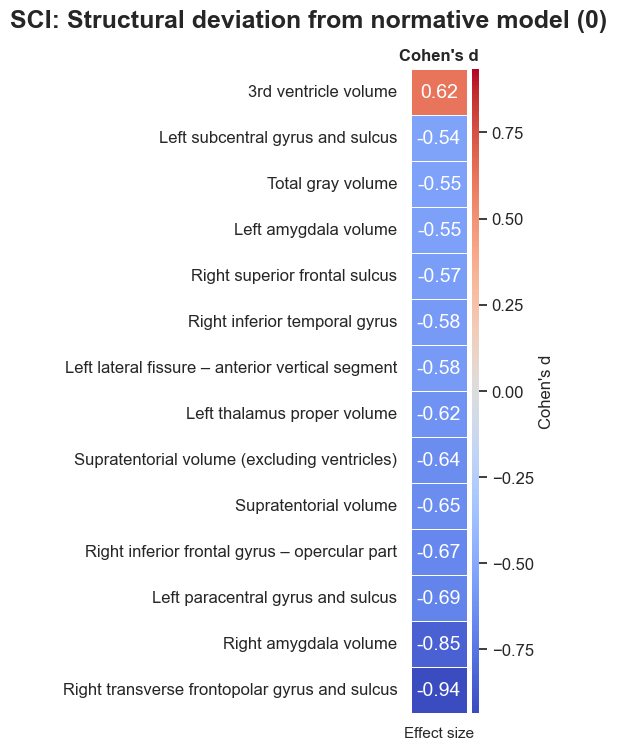

In [24]:
# Mapping of technical feature names to names for figures
region_name_map = {
    "rh_G_and_S_transv_frontopol_thickness": "Right transverse frontopolar gyrus and sulcus",
    "Right-Amygdala (Vol)": "Right amygdala volume",
    "lh_G_and_S_paracentral_thickness": "Left paracentral gyrus and sulcus",
    "rh_G_front_inf-Opercular_thickness": "Right inferior frontal gyrus – opercular part",
    "SupraTentorialVol (Vol)": "Supratentorial volume",
    "SupraTentorialVolNotVent (Vol)": "Supratentorial volume (excluding ventricles)",
    "3rd-Ventricle (Vol)": "3rd ventricle volume",
    "Left-Thalamus-Proper (Vol)": "Left thalamus proper volume",
    "rh_G_temporal_inf_thickness": "Right inferior temporal gyrus",
    "lh_Lat_Fis-ant-Vertical_thickness": "Left lateral fissure – anterior vertical segment",
    "rh_S_front_sup_thickness": "Right superior frontal sulcus",
    "Left-Amygdala (Vol)": "Left amygdala volume",
    "TotalGrayVol (Vol)": "Total gray volume",
    "lh_G_and_S_subcentral_thickness": "Left subcentral gyrus and sulcus"
}

# Load data
df_SCI_1 = pd.read_excel( "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")

# Apply region name mapping
df_SCI_1["Region"] = (
    df_SCI_1["Region"]
    .str.replace("&", "_and_", regex=False)
    .str.replace("__", "_", regex=False)
    .str.strip()
    .replace(region_name_map)
)

#Filter significant regions (FDR corrected p < 0.05) and sort by effect size
df_SCI_1["Region"] = df_SCI_1["Region"].replace(region_name_map)
df_sig = df_SCI_1[df_SCI_1["p-value (FDR)"] < 0.05].copy()
df_sig_sorted = df_sig.sort_values("Effect size", ascending=False).reset_index(drop=True)



# Define color scale for effect sizes
vmin = df_sig_sorted["Effect size"].min()
vmax = df_sig_sorted["Effect size"].max()
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

# Nur 1 Spalte
cols = 1
#fig, ax = plt.subplots(figsize=(5, len(df_sig_sorted) * 0.5), constrained_layout=True)
fig_height = max(len(df_sig_sorted) * 0.5, 3)
fig, ax = plt.subplots(figsize=(5, fig_height), constrained_layout=True)
# Alle Daten auf einmal plotten
data = df_sig_sorted.set_index("Region")[["Effect size"]]

heatmap = sns.heatmap(
    data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    yticklabels=True,
    ax=ax,
    annot_kws={
        "color": "white",
        "fontsize": 14
    },
    cbar_kws={
        "label": "Effect Size",
        "shrink": 1,
        "aspect": 100,
        "pad": 0.02
    }
)

# Formatierung
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_title("Cohen's d", fontsize=12, fontweight="bold")
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=12)

# Colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label("Cohen's d", fontsize=12)

# Overall title
plt.suptitle("SCI: Structural deviation from normative model (0)", fontsize=18, fontweight="bold", y=1.05)

plt.show()



## Onyl significant features from 1. Analyses

In [25]:
# Load significant features from first analysis
df_first = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")
significant_regions = df_first[df_first["p-value (FDR)"] < 0.05]["Region"].tolist()

# # Filter residual columns based on these regions
residual_cols = [f"Residual_{r}" for r in significant_regions if f"Residual_{r}" in df_combined.columns]

# Calculate all three tests as usual – but only for filtered regions.
results = []

for col in residual_cols:
    region = col.replace("Residual_", "")
    sci_p = df_combined[df_combined["Cohort"] == "SCI_NP"][col].dropna()
    sci_nnp = df_combined[df_combined["Cohort"] == "SCI_nNP"][col].dropna()

    # Test 1: SCI_NP vs 0
    if len(sci_p) >= 4:
        stat, p_val = ttest_1samp(sci_p, popmean=0)
        effect_size = sci_p.mean() / sci_p.std(ddof=1)
        results.append({
            "Region": region,
            "Cohort": "SCI_NP",
            "Comparison": "vs 0",
            "Test": "t-test vs 0",
            "Statistic": round(stat, 3),
            "p-value": p_val,
            "Effect Size": round(effect_size, 3),
            "Effect Type": "Cohen's d",
            "n": len(sci_p)
        })

    # Test 2: SCI_nNP vs 0
    if len(sci_nnp) >= 4:
        stat, p_val = ttest_1samp(sci_nnp, popmean=0)
        effect_size = sci_nnp.mean() / sci_nnp.std(ddof=1)
        results.append({
            "Region": region,
            "Cohort": "SCI_nNP",
            "Comparison": "vs 0",
            "Test": "t-test vs 0",
            "Statistic": round(stat, 3),
            "p-value": p_val,
            "Effect Size": round(effect_size, 3),
            "Effect Type": "Cohen's d",
            "n": len(sci_nnp)
        })

    # Test 3: SCI_NP vs SCI_nNP
    if len(sci_p) >= 4 and len(sci_nnp) >= 4:
        stat, p_val = ttest_ind(sci_p, sci_nnp)
        n1, n2 = len(sci_p), len(sci_nnp)
        s1, s2 = sci_p.std(ddof=1), sci_nnp.std(ddof=1)

        # Weighted pooled SD
        pooled_sd = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        # Cohen's d
        effect_size = (sci_p.mean() - sci_nnp.mean()) / pooled_sd

        results.append({
            "Region": region,
            "Cohort": "Both",
            "Comparison": "SCI_NP vs SCI_nNP",
            "Test": "t-test between groups",
            "Statistic": round(stat, 3),
            "p-value": p_val,
            "Effect Size": round(effect_size, 3),
            "Effect Type": "Cohen's d",
            "n_SCI_P": len(sci_p),
            "n_SCI_nNP": len(sci_nnp)
        })

# Save
df_filtered_results = pd.DataFrame(results)

output_path = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/GroupComarpison_SignificantRegionsOnly_FV.xlsx"
df_filtered_results.to_excel(output_path, index=False)


### Region mapping with more understandable names (signficant ones)

In [26]:
region_name_map = {
    "rh_G&S_transv_frontopol_thickness": "Right transverse frontopolar gyrus and sulcus",
    "Right-Amygdala (Vol)": "Right amygdala volume",
    "lh_G&S_paracentral_thickness": "Left paracentral gyrus and sulcus",
    "rh_G_front_inf-Opercular_thickness": "Right inferior frontal gyrus – opercular part",
    "SupraTentorialVol (Vol)": "Supratentorial volume",
    "SupraTentorialVolNotVent (Vol)": "Supratentorial volume (excluding ventricles)",
    "3rd-Ventricle (Vol)": "3rd ventricle volume",
    "Left-Thalamus-Proper (Vol)": "Left thalamus proper volume",
    "rh_G_temporal_inf_thickness": "Right inferior temporal gyrus",
    "lh_Lat_Fis-ant-Vertical_thickness": "Left lateral fissure – anterior vertical segment",
    "rh_S_front_sup_thickness": "Right superior frontal sulcus",
    "Left-Amygdala (Vol)": "Left amygdala volume",
    "TotalGrayVol (Vol)": "Total gray volume",
    "lh_G&S_subcentral_thickness": "Left subcentral gyrus and sulcus"
}

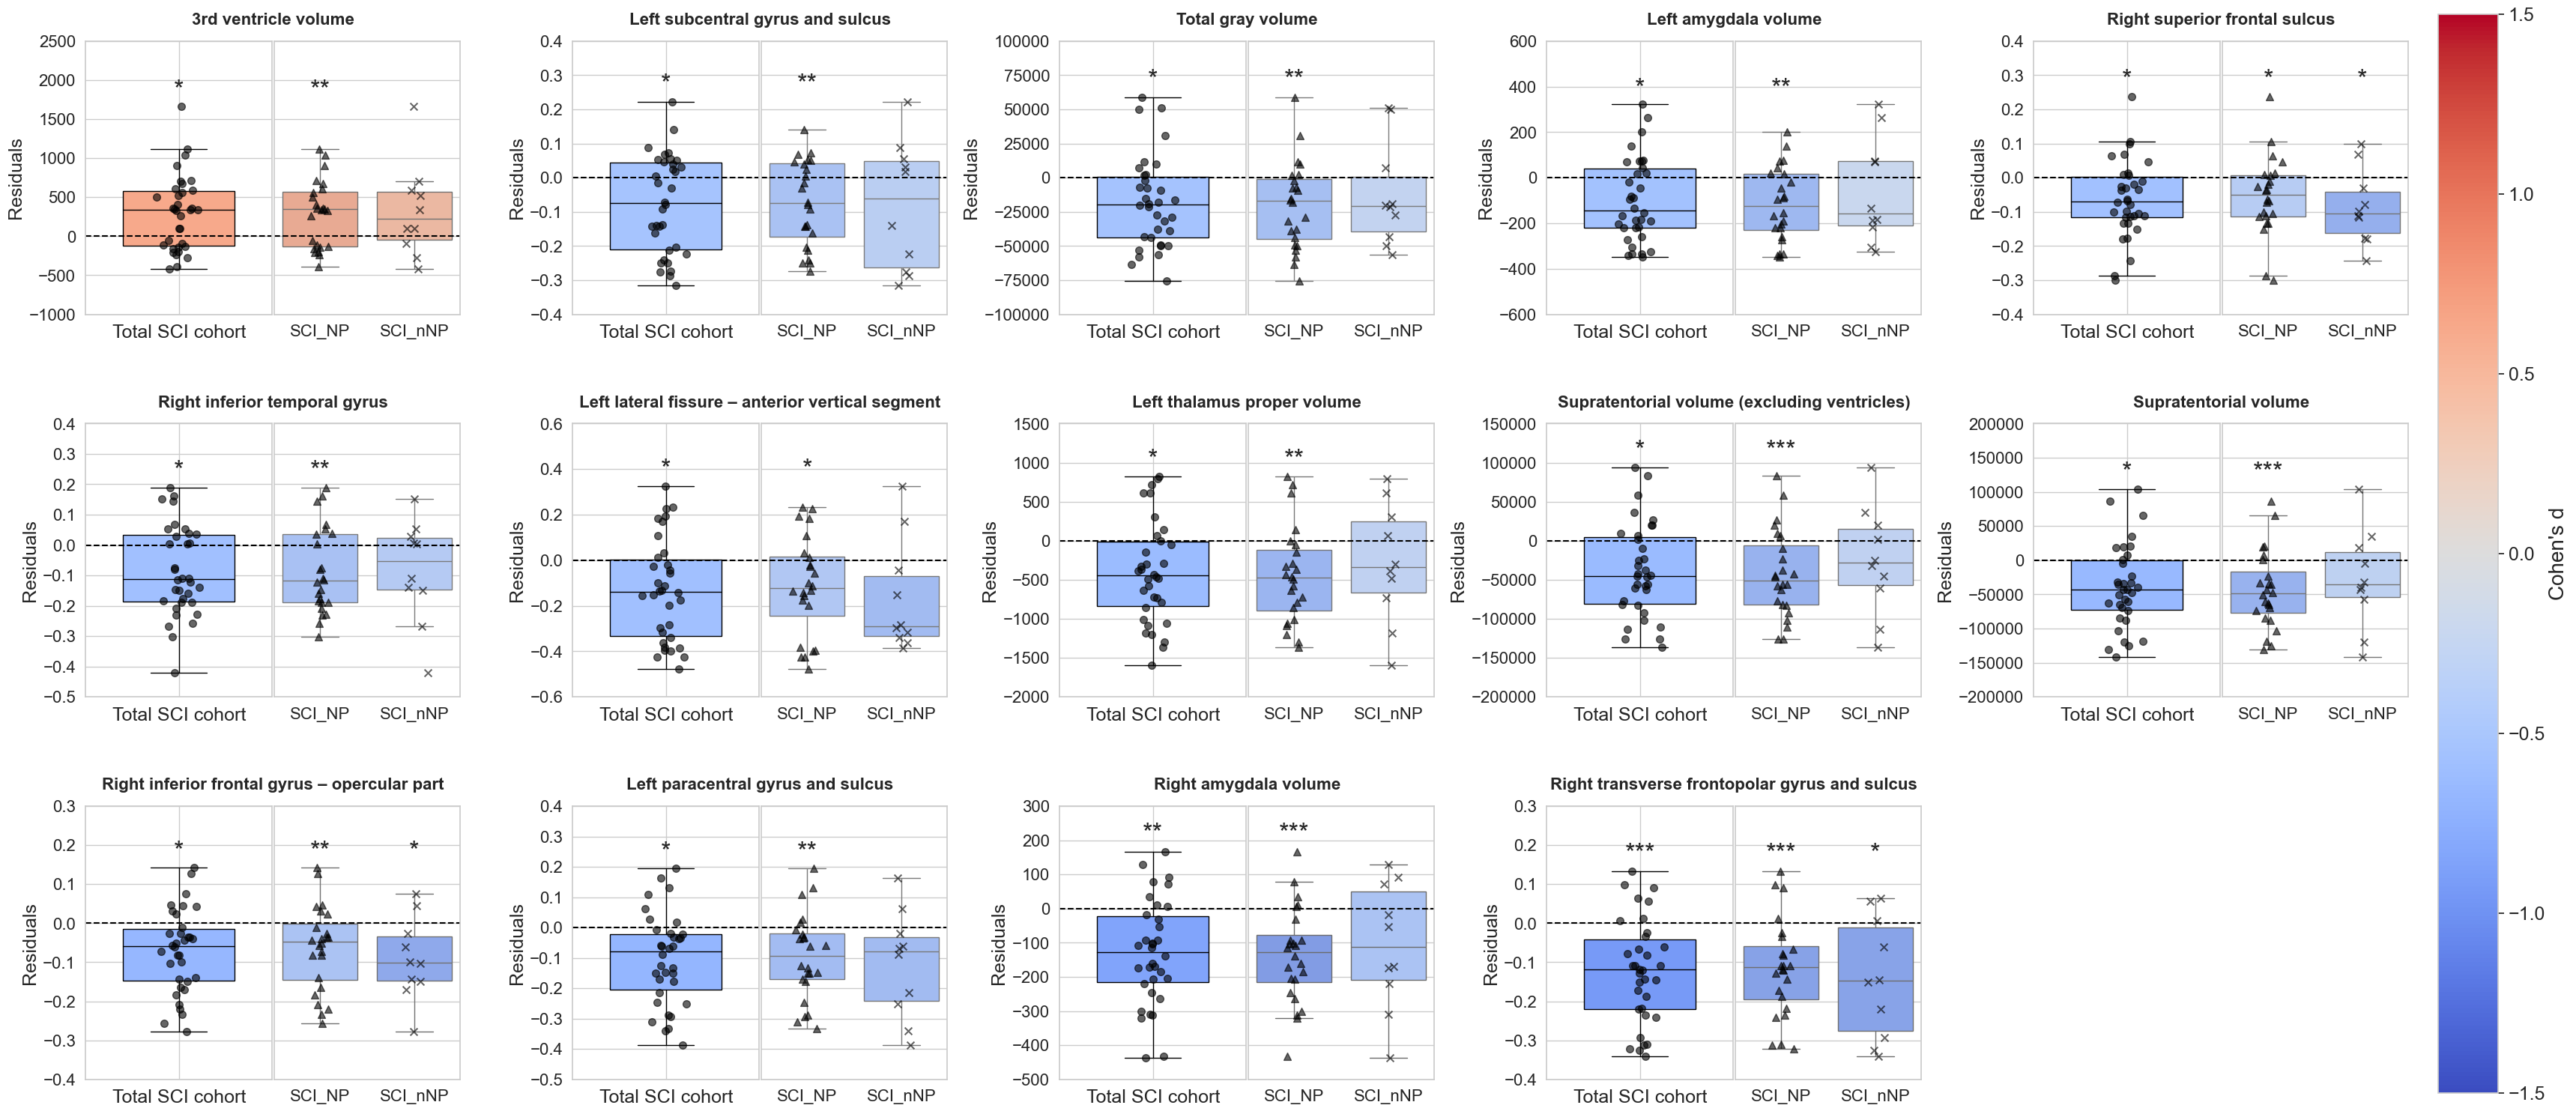

In [35]:
## Data loading
df_first = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")
raw_regions = df_first[df_first["p-value (FDR)"] < 0.05]["Region"].tolist()

# Cohen's d from the first file (for All SCI vs 0)
df_first["Region_key"] = df_first["Region"].str.replace("&", "_and_").str.replace("__", "_").str.strip()
cohen_d_all = df_first.set_index("Region_key")["Effect size"].to_dict()

# Sort by effect strength from df_first
df_sig_sorted = df_first[df_first["p-value (FDR)"] < 0.05].copy()
df_sig_sorted["Region_key"] = df_sig_sorted["Region"].str.replace("&", "_and_").str.replace("__", "_").str.strip()
df_sig_sorted = df_sig_sorted.sort_values("Effect size", ascending=False)

# Only transfer regions for which residual columns exist
valid_regions = []
for region, d in zip(df_sig_sorted["Region"], df_sig_sorted["Effect size"]):
    if f"Residual_{region}" in df_combined.columns:
        pretty = region_name_map.get(region, region)
        valid_regions.append((region, pretty))


df_group_stats = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/GroupComarpison_SignificantRegionsOnly_FV.xlsx")
df_group_stats["Region_key"] = df_group_stats["Region"].str.replace("&", "_and_").str.replace("__", "_").str.strip()

# Dictionaries
pval_vs0 = df_group_stats[df_group_stats["Comparison"] == "vs 0"].set_index(["Region_key", "Cohort"])["p-value"].to_dict()
pval_vs_group = df_group_stats[df_group_stats["Comparison"] == "SCI_NP vs SCI_nNP"].set_index("Region_key")["p-value"].to_dict()

# Effect size map (assuming the column is called “Cohen's d”)
cohen_d_vs0 = df_group_stats[df_group_stats["Comparison"] == "vs 0"].set_index(["Region_key", "Cohort"])["Effect Size"].to_dict()


df_filtered = df_combined[df_combined["Cohort"].isin(["SCI_NP", "SCI_nNP"])]
regions_per_row = 5
rows = math.ceil(len(significant_regions) / regions_per_row)

max_fig_height = 40  # Max Höhe in inches
fig_height = min(rows * 6, max_fig_height)
fig = plt.figure(figsize=(regions_per_row * 8, fig_height))
outer = gridspec.GridSpec(rows, regions_per_row, wspace=0.3, hspace=0.4)

def get_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


# Standardization for the color scale: adjust range if necessary!
norm = mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
cmap = cm.get_cmap("coolwarm")


for idx, (region, pretty_region) in enumerate(valid_regions):
    residual_col = f"Residual_{region}"
    if residual_col not in df_combined.columns:
        continue

    region_key = region.replace("&", "_and_").replace("__", "_").strip()

    row = idx // regions_per_row
    col = idx % regions_per_row


    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[row, col], wspace=0.01)
    ax_all = plt.Subplot(fig, inner[0])
    ax_group = plt.Subplot(fig, inner[1])
    ax_group.sharey(ax_all)  # <<< Das ist neu!
    fig.add_subplot(ax_all)
    fig.add_subplot(ax_group)


# Plot 1: All SCI
    vals_all = df_combined[df_combined["Cohort"].isin(["SCI_NP", "SCI_nNP"])][residual_col].dropna()

    # Cohen's d for all SCI from first file
    cohen_val = cohen_d_all.get(region_key, 0)

    box_color = cmap(norm(cohen_val))

    # New, manual grouping (x=0 for All SCI)
    ax_all.boxplot(
        [vals_all],
        positions=[0],
        patch_artist=True,
        boxprops=dict(facecolor=box_color),
        showfliers=False,
        widths=0.6,
        medianprops=dict(color='black')
    )

    jitter = np.random.normal(loc=0, scale=0.05, size=len(vals_all))
    ax_all.scatter(jitter, vals_all, color="black", alpha=0.6, s=49, zorder=3, marker="o", label="Total SCI")
    ax_all.axhline(0, color="black", linestyle="--")
    ax_all.set_xticks([0])
    ax_all.set_xticklabels(["Total SCI cohort"], fontsize=18)
    ax_all.tick_params(axis='y', labelsize=16)
    ax_all.set_ylabel("Residuals", fontsize = 18)
    # Add significance star for Total SCI cohort
    # Berechne y_max und y_range VORHER
    all_vals = pd.concat([
        df_filtered[df_filtered["Cohort"] == "SCI_NP"][residual_col],
        df_filtered[df_filtered["Cohort"] == "SCI_nNP"][residual_col],
        vals_all  # auch Total SCI einbeziehen
    ]).dropna()

    y_min = all_vals.min()
    y_max = all_vals.max()
    y_range = y_max - y_min if y_max != y_min else 1
    y_buffer = y_range * 0.2
    ylim = (y_min - 0.1 * y_range, y_max + y_buffer)

    # Setze y-Limits
    ax_all.set_ylim(ylim)
    ax_group.set_ylim(ylim)

    # Jetzt sind y_max und y_range definiert: Platziere Stern
    p_total_sci = df_first.set_index("Region_key").loc[region_key, "p-value (FDR)"]
    if not pd.isna(p_total_sci) and p_total_sci < 0.05:
        ax_all.text(0, y_max + y_range * 0.05, get_star(p_total_sci), ha='center', fontsize=25)






# Plot 2: Group comparison
    # Cohen's d for group plots
    cohen_d_p = cohen_d_vs0.get((region_key, "SCI_NP"), 0)
    cohen_d_nnp = cohen_d_vs0.get((region_key, "SCI_nNP"), 0)

    color_p = cmap(norm(cohen_d_p))
    color_nnp = cmap(norm(cohen_d_nnp))

    palette = {"SCI_NP": color_p, "SCI_nNP": color_nnp}
    sns.boxplot(data=df_filtered, x="Cohort", y=residual_col, ax=ax_group, palette=palette, showfliers=False, order=["SCI_NP", "SCI_nNP"])

    # SCI_NP = triangle (^)
    group1 = df_filtered[df_filtered["Cohort"] == "SCI_NP"]
    ax_group.scatter(
        x=np.random.normal(loc=0, scale=0.05, size=len(group1)),
        y=group1[residual_col],
        marker="^",
        color="black",
        alpha=0.6,
        s=50,
        label="SCI_NP",
        zorder=3
    )

# Points for SCI_nNP (group 2)
    # SCI_nNP = Cross (x)
    group2 = df_filtered[df_filtered["Cohort"] == "SCI_nNP"]
    ax_group.scatter(
        x=np.random.normal(loc=1, scale=0.05, size=len(group2)),
        y=group2[residual_col],
        marker="x",
        color="black",
        alpha=0.6,
        s=50,
        label="SCI_nNP",
        zorder=3
    )

    ax_group.axhline(0, color="black", linestyle="--")
    ax_group.set_ylabel("")
    ax_group.set_xlabel("")
    ax_group.tick_params(axis='x', labelsize=16)


    pos_all = ax_all.get_position()
    pos_group = ax_group.get_position()
    mid_x = (pos_all.x0 + pos_group.x1) / 2
    top_y = pos_all.y1 + 0.01

    fig.text(mid_x, top_y, pretty_region, ha='center', va='bottom', fontsize=16, weight='bold')

    # Calculate common y-axis
    all_vals = pd.concat([
        df_filtered[df_filtered["Cohort"] == "SCI_NP"][residual_col],
        df_filtered[df_filtered["Cohort"] == "SCI_nNP"][residual_col]
    ]).dropna()
    y_min = all_vals.min()
    y_max = all_vals.max()
    y_range = y_max - y_min if y_max != y_min else 1
    y_buffer = y_range * 0.2
    ylim = (y_min - 0.1 * y_range, y_max + y_buffer)

     # Set common y-axis
    ax_all.set_ylim(ylim)
    ax_group.set_ylim(ylim)

    # Align Y-axis ticks
    ax_group.set_yticks(ax_all.get_yticks())

    # Show only left, suppress right
    ax_group.tick_params(axis='y', labelleft=False, left=False)

    # Stars (significant)
    try:
        p = pval_vs0.get((region_key, "SCI_NP"), None)
        if p is not None and p < 0.05:
            ax_group.text(0, y_max + y_range * 0.05, get_star(p), ha='center', fontsize=25)
    except: pass

    try:
        p = pval_vs0.get((region_key, "SCI_nNP"), None)
        if p is not None and p < 0.05:
            ax_group.text(1, y_max + y_range * 0.05, get_star(p), ha='center', fontsize=25)
    except: pass

    try:
        p = pval_vs_group.get(region_key, None)
        if p is not None and p < 0.05:
            ax_group.text(0.5, y_max + y_range * 0.15, get_star(p), ha='center', fontsize=14, color="blue")
    except: pass



#plt.suptitle("Residuals – SCI overall + Subgroups", fontsize=22, y=0.92)"
# Make space before inserting text
plt.tight_layout(rect=[0, 0, 1, 0.90]) # Enough space for all regional titles above

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, cax=cbar_ax, label="Cohen's d")
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Cohen's d", fontsize=20)
fig.colorbar(sm, cax=cbar_ax, label="Cohen's d")
plt.show()
fig.savefig("brain_residuals_plot.pdf", format="pdf", bbox_inches="tight")
fig.savefig("Residuals_SCI_All_and_Subgroups.png", dpi=600, bbox_inches="tight")

### SCI with neuropathic pain and SCI witout neuropathic pain

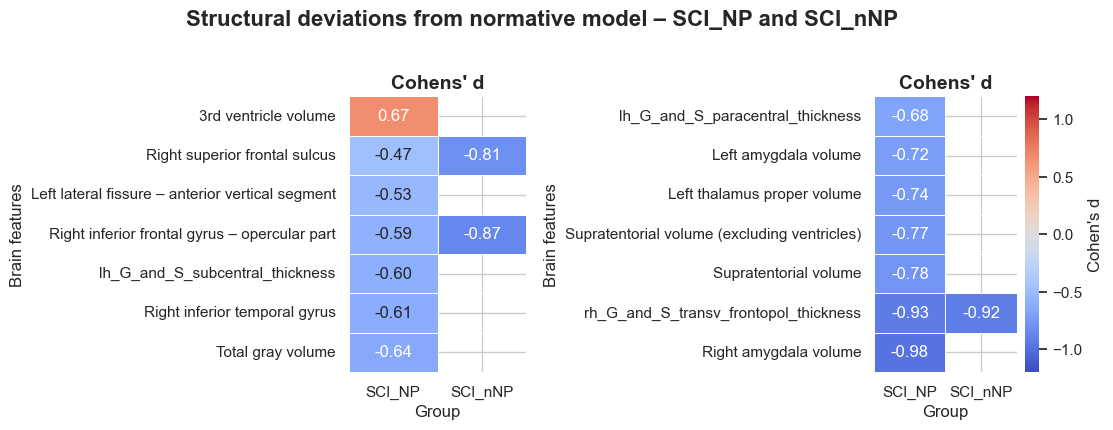

In [28]:
# Loading data
df = pd.read_excel(
    "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/GroupComarpison_SignificantRegionsOnly_FV.xlsx"
)

df["Region"] = (
    df["Region"]
    .str.replace("&", "_and_", regex=False)
    .str.replace("__", "_", regex=False)
    .str.strip()
    .replace(region_name_map)
)

df["Region"] = df["Region"].replace(region_name_map)

# Only SCI_NP und SCI_nNP vs 0
df = df[(df["Comparison"] == "vs 0") & (df["Cohort"].isin(["SCI_NP", "SCI_nNP"]))]

# Pivot table
effect_matrix = df.pivot(index="Region", columns="Cohort", values="Effect Size")
pval_matrix = df.pivot(index="Region", columns="Cohort", values="p-value")

# Sifinificance mask
significance_mask = pval_matrix < 0.05
masked_effects = effect_matrix.where(significance_mask)

# Sort after SCI_NP
masked_effects = masked_effects.sort_values("SCI_NP", ascending=False)

# Split in 2
n = len(masked_effects)
mid = math.ceil(n / 2)
chunks = [masked_effects.iloc[:mid], masked_effects.iloc[mid:]]

# Plot: 2 Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(11, 0.3 * n), sharex=True, sharey=False)

for i, chunk in enumerate(chunks):
    sns.heatmap(
        chunk,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        vmin=-1.2,
        vmax=1.2,
        linewidths=0.5,
        cbar=(i == 1),
        cbar_kws={"label": "Cohen's d"} if i == 1 else None,
        mask=chunk.isnull(),
        ax=axes[i]
    )
    axes[i].set_title("Cohens' d", fontsize=14, weight="bold")
    axes[i].set_xlabel("Group")
    axes[i].set_ylabel("Brain features")

# Titel
plt.suptitle("Structural deviations from normative model – SCI_NP and SCI_nNP", fontsize=16, weight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [29]:
### Region mapping with more understandable names (signficant ones)
region_name_map = {
    "rh_G&S_transv_frontopol_thickness": "Right transverse frontopolar gyrus and sulcus",
    "Right-Amygdala (Vol)": "Right amygdala volume",
    "lh_G&S_paracentral_thickness": "Left paracentral gyrus and sulcus",
    "rh_G_front_inf-Opercular_thickness": "Right inferior frontal gyrus – opercular part",
    "SupraTentorialVol (Vol)": "Supratentorial volume",
    "SupraTentorialVolNotVent (Vol)": "Supratentorial volume (excluding ventricles)",
    "3rd-Ventricle (Vol)": "3rd ventricle volume",
    "Left-Thalamus-Proper (Vol)": "Left thalamus proper volume",
    "rh_G_temporal_inf_thickness": "Right inferior temporal gyrus",
    "lh_Lat_Fis-ant-Vertical_thickness": "Left lateral fissure – anterior vertical segment",
    "rh_S_front_sup_thickness": "Right superior frontal sulcus",
    "Left-Amygdala (Vol)": "Left amygdala volume",
    "TotalGrayVol (Vol)": "Total gray volume",
    "lh_G&S_subcentral_thickness": "Left subcentral gyrus and sulcus"
}

# MAX PAIN For the significant Regions

✅ Correlation results (all SCI) saved as 'Correlation_Residuals_Pain.xlsx'


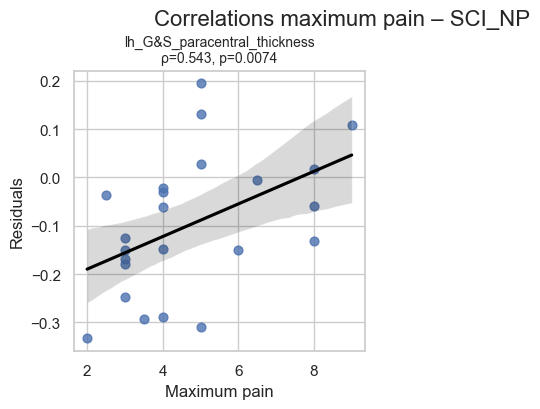

In [30]:
# Load significant regions from analysis 1 (with FDR)
df_sig = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")

# Filter for significant regions
significant_regions = df_sig[df_sig["p-value (FDR)"] < 0.05]["Region"].tolist()

correlation_results_pain = []

# SCI participants only (both groups together)
df_sci_only = df_sci_only = df_combined[df_combined["Cohort"] == "SCI_NP"]

#  Only use regions that were previously significant
for region in significant_regions:
    residual_col = f"Residual_{region}"

    if residual_col not in df_sci_only.columns:
        continue

    data = df_sci_only[[residual_col, "max_pain"]].dropna()

    if not data.empty:
        rho, p = spearmanr(data[residual_col], data["max_pain"])
        correlation_results_pain.append({
            "Region": region,
            "Spearman ρ": round(rho, 3),
            "p-value": round(p, 4),
            "n": len(data)
        })

# Data frame
results_df_all = pd.DataFrame(correlation_results_pain)
# Normalize region names as in mapping (for mapping comparison)
results_df_all["Region_key"] = (
    results_df_all["Region"]
    .str.replace("&", "_and_", regex=False)
    .str.replace("__", "_", regex=False)
    .str.strip()
)
# Save
output_path_all = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Correlation_Residuals_MAXPain_Signficant_Regions_FV.xlsx"
results_df_all.to_excel(output_path_all, index=False)

print("✅ Correlation results (all SCI) saved as 'Correlation_Residuals_Pain.xlsx'")


# Filter only significant correlations
df_sig_corr = results_df_all[results_df_all["p-value"] < 0.05]

# Normalize region names for mapping
df_sig_corr["Region_pretty"] = df_sig_corr["Region_key"].map(region_name_map)
df_sig_corr["Region_pretty"] = df_sig_corr["Region_pretty"].fillna(df_sig_corr["Region"])  # fallback

# Determine number of subplots
num_plots = len(df_sig_corr)
cols = 2
rows = math.ceil(num_plots / cols)

# Set plot size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 4))
axes = axes.flatten()

# Plot per significant region
for i, (_, row) in enumerate(df_sig_corr.iterrows()):
    region = row["Region"]
    residual_col = f"Residual_{region}"

    # Get the data again from df_sci_only
    data = df_sci_only[[residual_col, "max_pain"]].dropna()

    sns.regplot(
        y=residual_col,
        x="max_pain",
        data=data,
        ax=axes[i],
        scatter_kws={'s': 40, 'alpha': 0.8},
        line_kws={'color': 'black'}
    )
    pretty_name = row["Region_pretty"]
    axes[i].set_title(f"{pretty_name}\nρ={row['Spearman ρ']}, p={row['p-value']}", fontsize=10)

    axes[i].set_xlabel("Maximum pain")
    axes[i].set_ylabel("Residuals")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Correlations maximum pain – SCI_NP", fontsize=16, y=1.02)
plt.show()



### Average Pain correlations

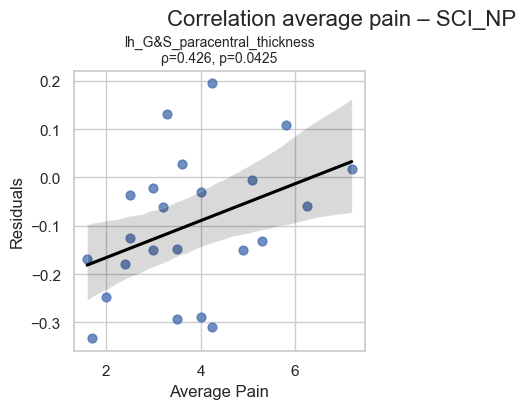

In [31]:
# Load significant regions from analysis 1 (with FDR)
df_sig = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")

# Filter for significant regions
significant_regions = df_sig[df_sig["p-value (FDR)"] < 0.05]["Region"].tolist()

correlation_results_pain = []

# Only SCI_Pain
df_sci_only = df_combined[df_combined["Cohort"] == "SCI_NP"]

# Only signficant features
for region in significant_regions:
    residual_col = f"Residual_{region}"

    if residual_col not in df_sci_only.columns:
        continue

    data = df_sci_only[[residual_col, "avg_pain"]].dropna()

    if not data.empty:
        rho, p = spearmanr(data[residual_col], data["avg_pain"])
        correlation_results_pain.append({
            "Region": region,
            "Spearman ρ": round(rho, 3),
            "p-value": round(p, 4),
            "n": len(data)
        })

# Dataframe
results_df_all = pd.DataFrame(correlation_results_pain)

# Save
output_path_all = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Correlation_Residuals_AvgPain_Signficant_Regions_FV.xlsx"
results_df_all.to_excel(output_path_all, index=False)

# Filter for significant features
df_sig_corr = results_df_all[results_df_all["p-value"] < 0.05]
# Normalized region names for mapping
df_sig_corr["Region_key"] = (
    df_sig_corr["Region"]
    .str.replace("&", "_and_", regex=False)
    .str.replace("__", "_", regex=False)
    .str.strip()
)
df_sig_corr["Region_pretty"] = df_sig_corr["Region_key"].map(region_name_map)
df_sig_corr["Region_pretty"] = df_sig_corr["Region_pretty"].fillna(df_sig_corr["Region"])  # fallback

# Determine number of subplots
num_plots = len(df_sig_corr)
cols = 2
rows = math.ceil(num_plots / cols)

# Set plot size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 4))
axes = axes.flatten()

# Plot per significant region
for i, (_, row) in enumerate(df_sig_corr.iterrows()):
    region = row["Region"]
    residual_col = f"Residual_{region}"

    # Retrieve the data again from df_sci_only
    data = df_sci_only[[residual_col, "avg_pain"]].dropna()

    sns.regplot(
        y=residual_col,
        x="avg_pain",
        data=data,
        ax=axes[i],
        scatter_kws={'s': 40, 'alpha': 0.8},
        line_kws={'color': 'black'}
    )
    pretty_name = row["Region_pretty"]
    axes[i].set_title(f"{pretty_name}\nρ={row['Spearman ρ']}, p={row['p-value']}", fontsize=10)
    axes[i].set_xlabel("Average Pain")
    axes[i].set_ylabel("Residuals")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Correlation average pain – SCI_NP", fontsize=16, y=1.02)
plt.show()

### Spatial extent pain

In [32]:
# Load significant regions from analysis 1 (with FDR)
df_sig = pd.read_excel("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx")

# Filter for significant regions
significant_regions = df_sig[df_sig["p-value (FDR)"] < 0.05]["Region"].tolist()

correlation_results_pain = []

# SCI Pain
df_sci_only = df_combined[df_combined["Cohort"] == "SCI_NP"]

# Use only regions that were previously significant
for region in significant_regions:
    residual_col = f"Residual_{region}"

    if residual_col not in df_sci_only.columns:
        continue

    data = df_sci_only[[residual_col, "spatial_ext_pain"]].dropna()

    if not data.empty:
        rho, p = spearmanr(data[residual_col], data["spatial_ext_pain"])
        correlation_results_pain.append({
            "Region": region,
            "Spearman ρ": round(rho, 3),
            "p-value": round(p, 4),
            "n": len(data)
        })

# Data frame
results_df_all = pd.DataFrame(correlation_results_pain)

# Save
output_path_all = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/Correlation_Residuals_SpatialPain_Signficant_Regions_FV.xlsx"
results_df_all.to_excel(output_path_all, index=False)

# Filter only significant correlations
df_sig_corr = results_df_all[results_df_all["p-value"] < 0.05]
# Normalized region names for mapping
df_sig_corr["Region_key"] = (
    df_sig_corr["Region"]
    .str.replace("&", "_and_", regex=False)
    .str.replace("__", "_", regex=False)
    .str.strip()
)
df_sig_corr["Region_pretty"] = df_sig_corr["Region_key"].map(region_name_map)
df_sig_corr["Region_pretty"] = df_sig_corr["Region_pretty"].fillna(df_sig_corr["Region"])  # fallback

# Determine number of subplots
num_plots = len(df_sig_corr)
cols = 2
rows = math.ceil(num_plots / cols)

# Set plot size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 4))
axes = axes.flatten()

# Plot per significant region
for i, (_, row) in enumerate(df_sig_corr.iterrows()):
    region = row["Region"]
    residual_col = f"Residual_{region}"

    # Retrieve the data again from df_sci_only
    data = df_sci_only[[residual_col, "spatial_ext_pain"]].dropna()

    sns.regplot(
        y=residual_col,
        x="spatial_ext_pain",
        data=data,
        ax=axes[i],
        scatter_kws={'s': 40, 'alpha': 0.8},
        line_kws={'color': 'black'}
    )
    pretty_name = row["Region_pretty"]
    axes[i].set_title(f"{pretty_name}\nρ={row['Spearman ρ']}, p={row['p-value']}", fontsize=10)
    axes[i].set_xlabel("Spatial extent pain")
    axes[i].set_ylabel("Residuals")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Correlationen spatial extent pain – SCI_NP", fontsize=16, y=1.02)
plt.show()


KeyboardInterrupt: 